In [2]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
#print(f'Number of nodes: {data.num_nodes}')
#print(f'Number of edges: {data.num_edges}')
#print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
#print(f'Has isolated nodes: {data.has_isolated_nodes()}')
#print(f'Has self-loops: {data.has_self_loops()}')
#print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


**1 a)** From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. Discuss briefly the implications for supervised
versus semi-supervised learning.

In [4]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


We dont have very many labeled nodes for training, so supervised learning will struggle. Only being able to train on 140 noded means that it will be hard to learn in a way that generalizes over the whole data set. We do however have quite a number of nodes in validation, so semi-supervised learning could be able to produce better results by inferring labels to the rest of the data set???? 

**b)** Train both a standard dense network using supervised learning and network using the convolution from equation 1 using semi-supervised learning

and 

**c)** In both cases, implement 'early stopping' using the validation set, i.e. the training should evaluate against the validation set to stop training when this fails to improve.

In [13]:
# First a standard dense network
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import copy


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

mlp_model = MLP(hidden_channels=16)
print(mlp_model)


mlp_model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def mlp_train():
      mlp_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = mlp_model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def mlp_test():
      mlp_model.eval()
      out = mlp_model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def mlp_validate(saved_models, accuracies):
    test_acc = mlp_test()
    accuracies = np.append(accuracies[1:], test_acc)

    model_copy = copy.deepcopy(mlp_model)
    saved_models = np.append(saved_models[1:], model_copy)
    
    return saved_models, accuracies


# TODO implement early stopping
patience = 5
s_accuracies = np.zeros(patience)
s_models = np.empty(patience)
s_models[:] = np.NaN

for epoch in range(1, 21):
    loss = mlp_train()
    s_models, s_accuracies = mlp_validate(s_models, s_accuracies)
    # Starta och stoppa någonting
    print(f'Saved Models: {s_models}')
    print(f'Accuracies: {s_accuracies}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)
Saved Models: [nan nan nan nan
 MLP(
   (lin1): Linear(in_features=1433, out_features=16, bias=True)
   (lin2): Linear(in_features=16, out_features=7, bias=True)
 )                                                             ]
Accuracies: [0.    0.    0.    0.    0.103]
Epoch: 001, Loss: 1.9615
Saved Models: [nan nan nan
 MLP(
   (lin1): Linear(in_features=1433, out_features=16, bias=True)
   (lin2): Linear(in_features=16, out_features=7, bias=True)
 )
 MLP(
   (lin1): Linear(in_features=1433, out_features=16, bias=True)
   (lin2): Linear(in_features=16, out_features=7, bias=True)
 )                                                             ]
Accuracies: [0.    0.    0.    0.103 0.132]
Epoch: 002, Loss: 1.9557
Saved Models: [nan nan MLP(
           (lin1): Linear(in_features=1433, out_features=16, bias=True)
           (lin2): Linear(in_features=16, out_fe

In [41]:
test_acc = mlp_test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


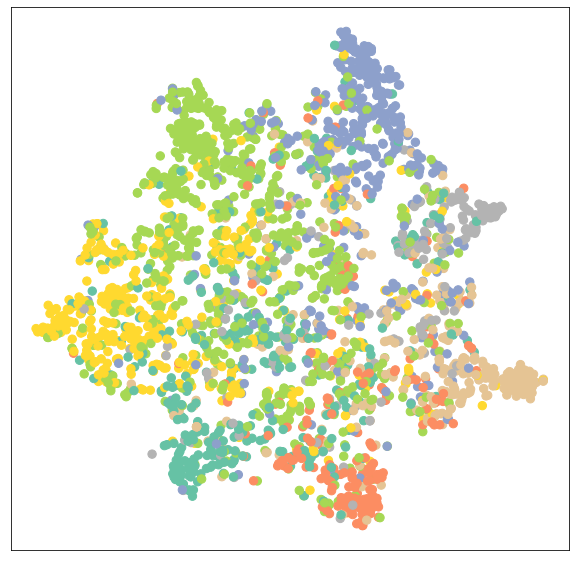

In [42]:
mlp_model.eval()

out = mlp_model(data.x)#, data.edge_index - Only nodes?
visualize(out, color=data.y)

 **Now for the network using graph convolutions**

In [43]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

gcn_model = GCN(hidden_channels=16)
print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [44]:
gcn_model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def gcn_train():
      gcn_model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = gcn_model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def gcn_test():
      gcn_model.eval()
      out = gcn_model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

# TODO implement early stopping
for epoch in range(1, 101):
    loss = gcn_train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [47]:
test_acc = gcn_test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


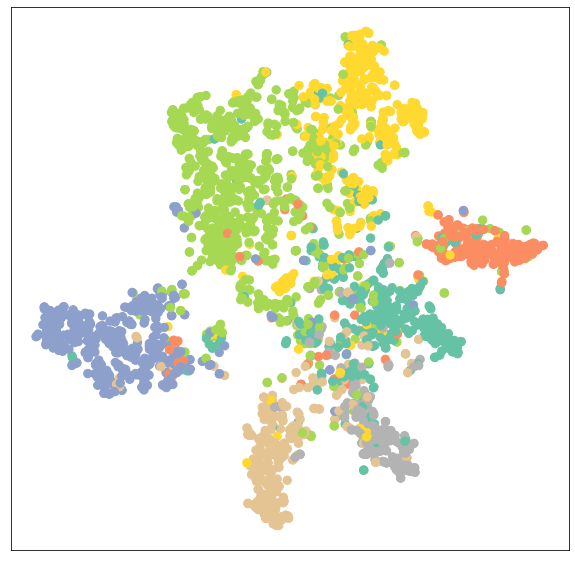

In [48]:
gcn_model.eval()

out = gcn_model(data.x, data.edge_index)
visualize(out, color=data.y)

**2)** Try to outperform the results from (1) using one of the more advances algorithms such as the graph attention network, from eqn. 3-4. Try to optimize performance, varying the number of heads (for GAT), different pooling layers, dropout, etc. (Extensive hyper-parameter tuning however is not asked for.)

It may not be that easy to improve the results from (1) much (see Cora Benchmark), the main objective here is to show that you have tried.